### Make plots from reco dataframe

In [1]:
import pickle
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from freedom.utils import i3cols_dataloader

In [2]:
# df = pd.read_pickle('/home/atfienberg/IceCube/freeDOM/examples/reco/'
#                     'chargenet_reco_08_31_2020-20_04_24.pkl')

# df = pd.read_pickle('/home/atfienberg/IceCube/freeDOM/examples/reco/'
#                     'chargenet_reco_2k_nuE_09_02_2020-18_51_11.pkl')
df = pd.read_pickle('/home/atfienberg/IceCube/freeDOM/examples/reco/'
                    'chargenet_reco_100k_numu_09_02_2020-23_04_20.pkl')

# df = pd.read_pickle('/home/atfienberg/IceCube/freeDOM/examples/reco/'
#                     'domnet_reco_08_31_2020-20_55_58.pkl')

# df = pd.read_pickle('fit_results_8_7_2020.pkl')

In [3]:
print('Nets used for this reconstruction:\n')
for key, value in df.attrs['reco_conf']['service_conf'].items():
    if key.endswith('file'):
        print(f'{value}\n')

Nets used for this reconstruction:

/home/atfienberg/freedomDataCopy/public_for_aaron/HitNet_ranger_14_Jul_2020-08h03/epoch_32_model.hdf5

ChargeNet_nChannels_22_May_2020-11h05/epoch_400_model.hdf5



In [4]:
try:
    i3_dir = df.attrs['i3cols_dirname']
    print('using i3cols loader')
    events = i3cols_dataloader.load_events(i3_dir, recos={'retro': 'retro_crs_prefit__median__neutrino'}, 
                                           include_doms=False)[0]
    if 'n_evts' in df.attrs['reco_conf']:
        events = events[:df.attrs['reco_conf']['n_evts']]

except KeyError:
    with open('/home/atfienberg/freedomDataCopy/public_for_aaron/test_events.pkl', 'rb') as f:
        events = pickle.load(f)

using i3cols loader


In [5]:
df.head()

,evt_idx,free_fit_llh,true_p_llh,retro_p_llh,n_calls,n_iters,x,y,z,time,azimuth,zenith,cascade energy,track energy
0,0,-81.465508,-70.387947,-71.848976,7098,335,-6.683051,17.952975,-347.273170,9834.399322,1.642693,1.677022,5.103281,0.954884
1,1,-27.823744,-23.692410,-22.618736,3385,176,23.386388,-94.104966,-468.232437,9737.358356,4.853941,2.221551,8.330592,1.271215
2,2,-27.966360,-21.420540,-23.027100,2731,138,122.156841,-67.560646,-400.694450,9796.933703,2.521262,0.838964,7.979319,3.079127
3,3,-96.624817,-88.146866,-84.633888,5719,280,-15.720562,-80.810079,-293.642807,9845.840513,2.915227,1.020141,5.024463,0.520954
4,4,-72.115715,-63.889477,-63.671101,3849,194,37.602583,-74.364079,-285.264093,9849.795390,5.188418,2.171225,5.040187,2.561606


In [6]:
# select events where we found an LLH about as good as the true parameters or better
good_df = pd.DataFrame(df[df.free_fit_llh < df.true_p_llh])
print(f'good frac: {len(good_df)/len(df):.2f}')
good_df = df

good frac: 0.94


In [7]:
par_names = ['x', 'y', 'z', 'time',
             'azimuth', 'zenith', 
             'cascade energy', 'track energy']

# grab true parameters and retro parameters
true_ps = np.empty((len(events), 8), dtype=np.float32)
retro_ps = np.empty_like(true_ps)
for i, event in enumerate(events):
    true_ps[i, :] = event['params']
    retro_ps[i, :] = event['retro']

In [8]:
good_retro = retro_ps[good_df.evt_idx]
good_true = true_ps[good_df.evt_idx]

In [9]:
retro_zen_diff = good_retro[:, 5] - good_true[:, 5]
freedom_zen_diff = good_df.zenith - good_true[:, 5]

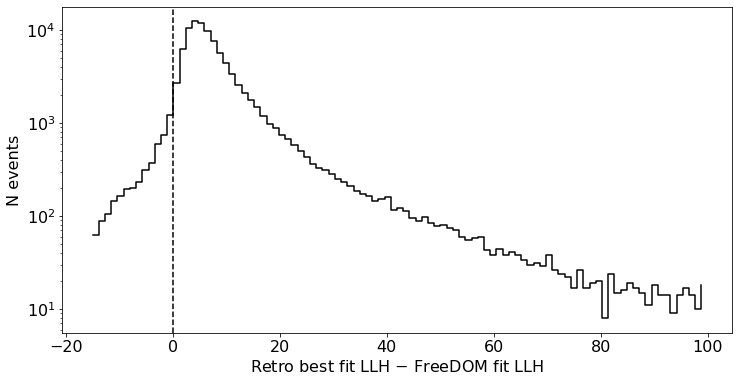

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

llh_diff = good_df.retro_p_llh - good_df.free_fit_llh
bins = np.linspace(-15, 100, 100)
hist, bins = np.histogram(llh_diff, bins)
ax.step(bins[:-1], hist, where='post', color='black')
ax.axvline(0, linestyle='--', color='black')
ax.set_xlabel('Retro best fit LLH $-$ FreeDOM fit LLH', fontsize=16)
ax.set_ylabel('N events', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')

In [11]:
def get_quantiles(vals, quantiles=[0.25, 0.5, 0.75]):
    vals = np.sort(vals)
    
    quant_vals = [vals[int(quant*len(vals))] for quant in quantiles]
    
    return quant_vals

In [12]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [13]:
def plot_quants(quants, ax, color, style='--', dashes=None):
    if dashes is not None:
        ax.axvline(quants[0], color=color, linestyle=style, linewidth=2, dashes=dashes)
        ax.axvline(quants[1], color=color, linestyle='-', linewidth=2)    
        ax.axvline(quants[2], color=color, linestyle=style, linewidth=2, dashes=dashes)    
    else:
        ax.axvline(quants[0], color=color, linestyle=style, linewidth=2)
        ax.axvline(quants[1], color=color, linestyle='-', linewidth=2)    
        ax.axvline(quants[2], color=color, linestyle=style, linewidth=2)    

[-0.26513076, -0.01830411, 0.1941626]
0.28119000000000005
0.5831700000000001
0.7677500000000002
[-0.2678036689758301, 0.007218003273010254, 0.280381441116333]
0.27944
0.5327900000000001
0.7523500000000001


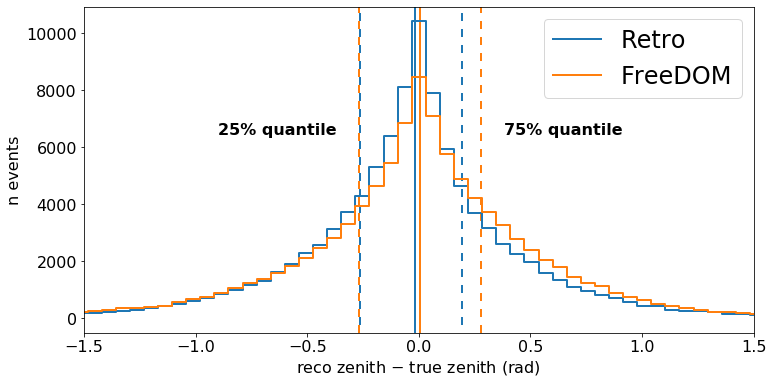

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
bins = np.linspace(-2*math.pi, 2*math.pi, 200)
retro_hist, bins = np.histogram(retro_zen_diff, bins=bins)
freedom_hist, bins = np.histogram(freedom_zen_diff, bins=bins)

retro_quants = get_quantiles(retro_zen_diff)
print(retro_quants)
# test sum
for quant in retro_quants:
    start_bin = np.argwhere(bins>quant)[0][0]
    print(np.sum(retro_hist[:start_bin]/np.sum(retro_hist)))

plot_quants(retro_quants, ax, color_cycle[0], dashes=(0, 4, 4, 0))

freedom_quants = get_quantiles(freedom_zen_diff)
plot_quants(freedom_quants, ax, color_cycle[1], dashes=(4, 4))
print(freedom_quants)
# test sum
for quant in freedom_quants:
    start_bin = np.argwhere(bins>quant)[0][0]
    print(np.sum(freedom_hist[:start_bin]/np.sum(freedom_hist)))

ax.step(bins[:-1], retro_hist, where='post', label='Retro', linewidth=2)
ax.step(bins[:-1], freedom_hist, where='post', label='FreeDOM', linewidth=2)


ylim = ax.get_ylim()
text_y = ylim[0] + 0.6*(ylim[1] - ylim[0])

ax.text(freedom_quants[0]-0.1, text_y, '25% quantile', 
        horizontalalignment='right', 
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.text(freedom_quants[2]+0.1, text_y, '75% quantile', 
        horizontalalignment='left',
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})

ax.set_xlim(-1.5, 1.5)

ax.set_xlabel('reco zenith $-$ true zenith (rad)', fontsize=16)
ax.set_ylabel('n events', fontsize=16)
ax.tick_params(labelsize=16)

ax.legend(fontsize=24)

plot_name='pres_plots/zenith_reco_domnet_quantiles.pdf'
fig.savefig(plot_name, bbox='tight')

In [15]:
def make_diff_plot(par_name, logy=False):
    ind = par_names.index(par_name)
    
    retro_diff = good_retro[:, ind] - good_true[:, ind]
    freedom_diff = good_df[par_name] - good_true[:, ind]
    
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    if not par_name.endswith('energy'):
        bins = np.linspace(freedom_diff.mean() - 2.5*freedom_diff.std(), 
                           freedom_diff.mean() + 2.5*freedom_diff.std(), 100)
    else:
        bins = np.linspace(-500, 100, 100)
    
    retro_hist, bins = np.histogram(retro_diff, bins=bins,)
    freedom_hist, bins = np.histogram(freedom_diff, bins=bins,)
    ax.step(bins[:-1], retro_hist, where='post', label='Retro', color='blue')
    ax.step(bins[:-1], freedom_hist, where='post', label='FreeDOM test', color='red')

    ax.set_xlabel(f' reco {par_name} $-$ true {par_name}', fontsize=16)
    ax.set_ylabel('n events', fontsize=16)
    ax.tick_params(labelsize=16)

    if logy:
        ax.set_yscale('log')
    
    ax.legend(fontsize=16)

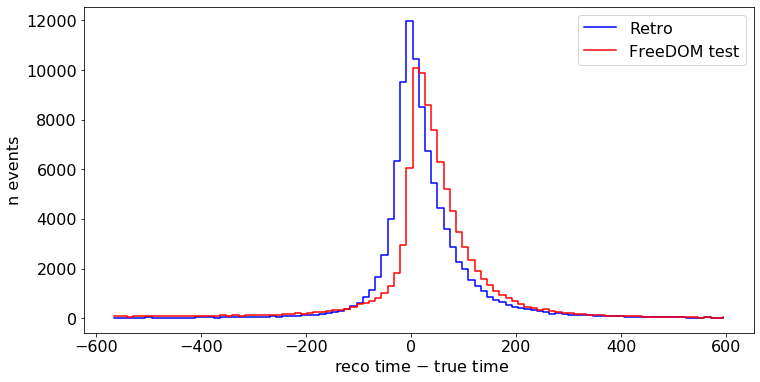

In [16]:
make_diff_plot('time', False)

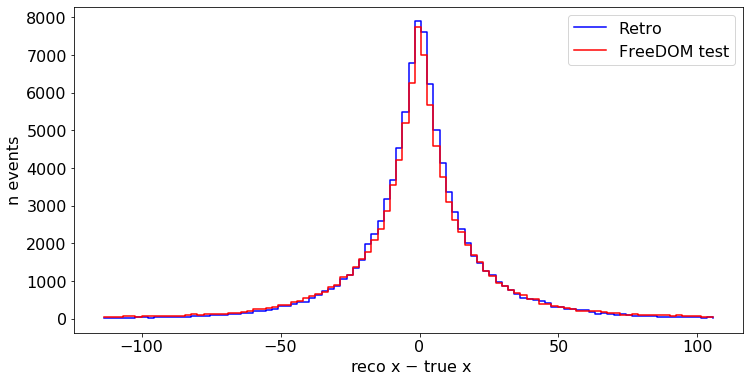

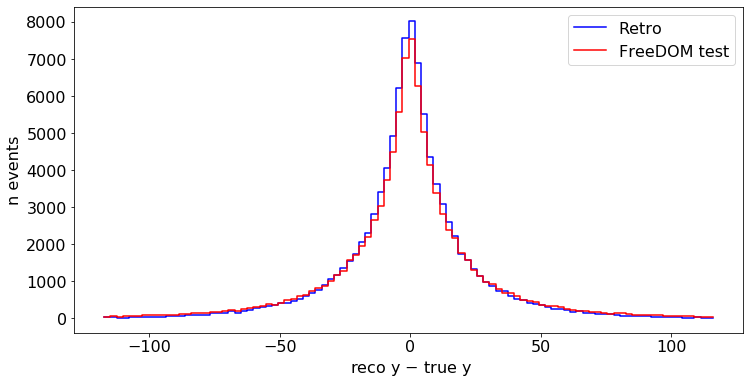

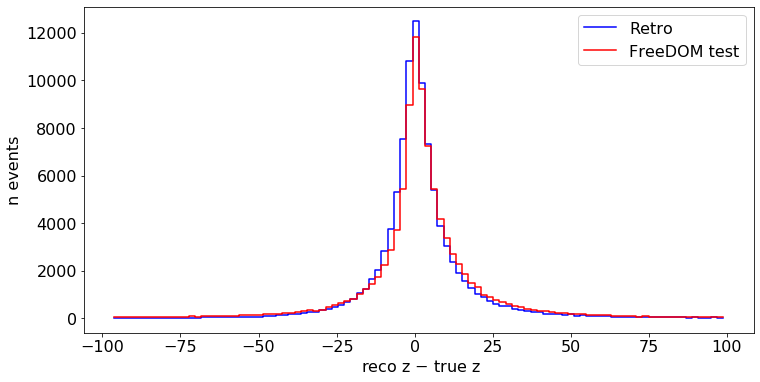

In [17]:
for par in ['x', 'y', 'z']:
    make_diff_plot(par, False)

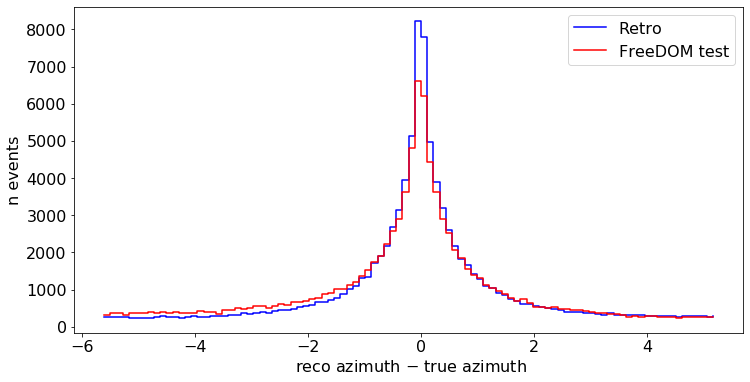

In [18]:
make_diff_plot('azimuth', False)

### energy plots

### 2-d energy reco plot

In [19]:
df["track energy"].max()

399.986121480953

In [20]:
good_true[:,-2].max()

9146.336

In [21]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

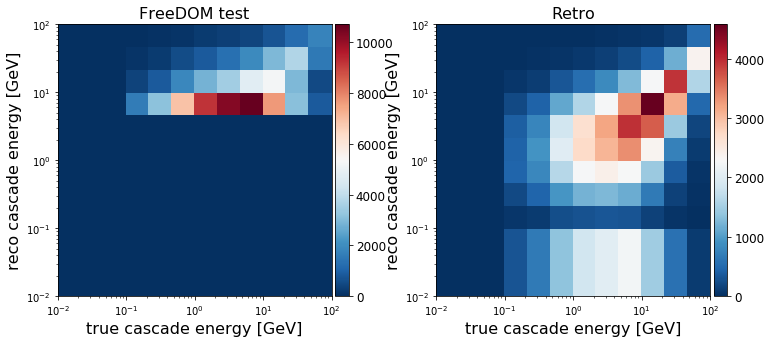

In [22]:
e_range = [0] + list(np.logspace(-1, 2, 10))

fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

true = good_true[:,-2]

labels = ['FreeDOM test', 'Retro']

for ax, reco, label in zip(ax.flat, (good_df['cascade energy'], good_retro[:, -2]), labels):
    H, x_edge, y_edge = np.histogram2d(true, reco, e_range)

    im = ax.pcolormesh(x_edge, y_edge, H.T, cmap='RdBu_r', rasterized=True)
    colorbar(im)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.01, 100)
    ax.set_ylim(0.01,100)
    ax.set_xlabel('true cascade energy [GeV]', fontsize=16)
    ax.set_ylabel('reco cascade energy [GeV]', fontsize=16)

    ax.set_title(label, fontsize=16)

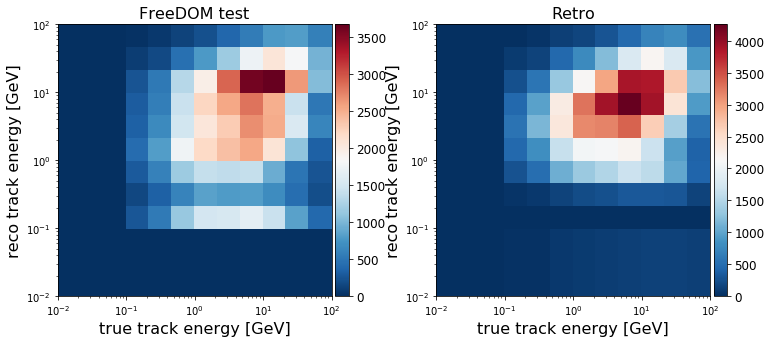

In [23]:
e_range = [0] + list(np.logspace(-1, 2, 10))

fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

true = good_true[:,-2]

labels = ['FreeDOM test', 'Retro']

for ax, reco, label in zip(ax.flat, (good_df['track energy'], good_retro[:, -1]), labels):
    H, x_edge, y_edge = np.histogram2d(true, reco, e_range)

    im = ax.pcolormesh(x_edge, y_edge, H.T, cmap='RdBu_r', rasterized=True)
    colorbar(im)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.01, 100)
    ax.set_ylim(0.01,100)
    ax.set_xlabel('true track energy [GeV]', fontsize=16)
    ax.set_ylabel('reco track energy [GeV]', fontsize=16)

    ax.set_title(label, fontsize=16)

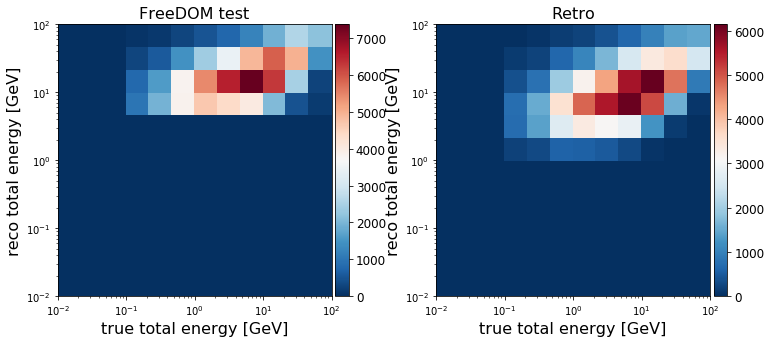

In [24]:
e_range = [0] + list(np.logspace(-1, 2, 10))

fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

true = good_true[:,-2]

labels = ['FreeDOM test', 'Retro']

for ax, reco, label in zip(ax.flat, (good_df['track energy']+good_df['cascade energy'], good_retro[:, -2:].sum(axis=1)), labels):
    H, x_edge, y_edge = np.histogram2d(true, reco, e_range)

    im = ax.pcolormesh(x_edge, y_edge, H.T, cmap='RdBu_r', rasterized=True)
    colorbar(im)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.01, 100)
    ax.set_ylim(0.01,100)
    ax.set_xlabel('true total energy [GeV]', fontsize=16)
    ax.set_ylabel('reco total energy [GeV]', fontsize=16)

    ax.set_title(label, fontsize=16)

In [25]:
retro_E_sums = good_retro[:, -2:].sum(axis=1)
true_E_sums = good_true[:, -2:].sum(axis=1)
good_df['e_tot'] = good_df['cascade energy'] + good_df['track energy']

In [26]:
true_e = np.clip(good_true[:, -2:], 0.001, 10000)
retro_E_log_diff = np.log10(retro_E_sums) - np.log10(true_E_sums)
retro_E_rat = (retro_E_sums - true_E_sums)/true_E_sums

freedom_E_log_diff = np.log10(good_df['e_tot']) - np.log10(true_E_sums)
freedom_E_rat = (good_df['e_tot'] - true_E_sums)/true_E_sums

In [27]:
cascade_log_e_rat = np.log10(good_df['cascade energy']) - np.log10(true_e[:, -2])
track_log_e_rat = np.log10(good_df['track energy']) - np.log10(true_e[:, -1])

retro_e = np.clip(good_retro[:, -2:], 0.001, 10000)
retro_cascade_log_e_rat = np.log10(retro_e[:, -2]) - np.log10(true_e[:, -2])
retro_track_log_e_rat = np.log10(retro_e[:, -1]) - np.log10(true_e[:, -1])

Text(0, 0.5, 'n events')

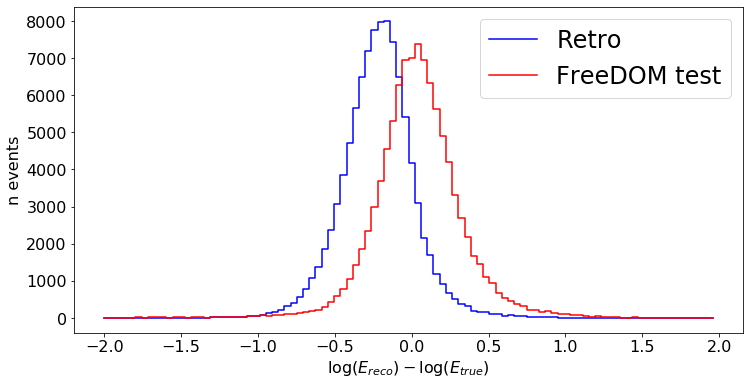

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-2, 2, 100)
for var, label, color in zip([retro_E_log_diff, freedom_E_log_diff], ['Retro', 'FreeDOM test'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    ax.step(bins[:-1], hist, where='post', label=label, color=color)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$\log(E_{reco}) - \log(E_{true})$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

Text(0, 0.5, 'n events')

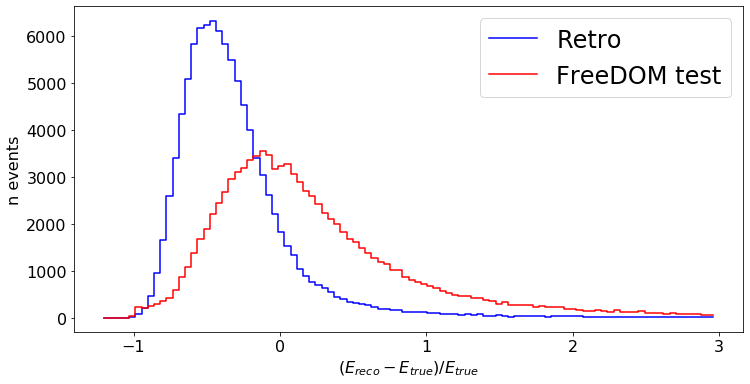

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-1.2, 3, 100)
e_rat_hists = []
for var, label, color in zip([retro_E_rat, freedom_E_rat], ['Retro', 'FreeDOM test'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    e_rat_hists.append(hist)
    
    ax.step(bins[:-1], hist, where='post', label=label, color=color)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$(E_{reco} - E_{true}) / E_{true}$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

# Remake the above plot after unbiasing the retro energies (via multiplicative scaling)
# set the median to 0

In [30]:
bin_centers = 0.5*(bins[:-1] + bins[1:])
# retro_E_rat_peak = np.average(bin_centers, weights=e_rat_hists[0])
retro_E_rat_peak = get_quantiles(retro_E_rat)[1]
corrected_retro_E = retro_E_sums / (retro_E_rat_peak+1)

# freedom_E_rat_peak = np.average(bin_centers, weights=e_rat_hists[1])
freedom_E_rat_peak = get_quantiles(freedom_E_rat)[1]
corrected_freedom_E = good_df['e_tot'] / (freedom_E_rat_peak+1)

In [31]:
cor_retro_E_log_diff = np.log10(corrected_retro_E) - np.log10(true_E_sums)
cor_retro_E_rat = (corrected_retro_E - true_E_sums)/true_E_sums

cor_freedom_E_log_diff = np.log10(corrected_freedom_E) - np.log10(true_E_sums)
cor_freedom_E_rat = (corrected_freedom_E - true_E_sums)/true_E_sums

0.28294
0.52639
0.7739799999999999
--
0.2537
0.52398
0.76894
--


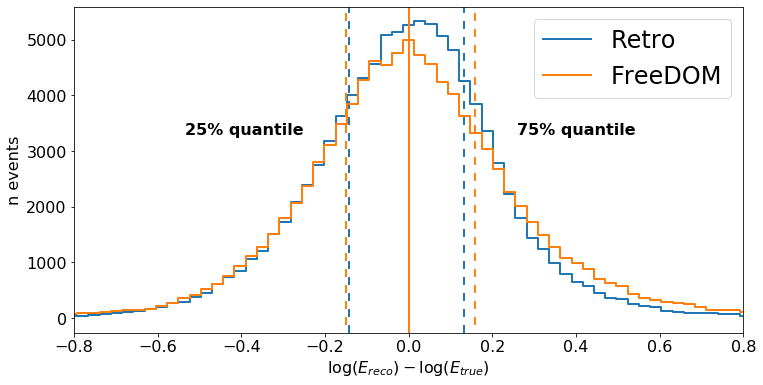

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-2, 2, 150)
i=0
for var, label, color in zip([cor_retro_E_log_diff, cor_freedom_E_log_diff], 
                             ['Retro', 'FreeDOM'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    quants = get_quantiles(var)
    for quant in quants:
        start_bin = np.argwhere(bins>=quant)[0][0]
        print(np.sum(hist[:start_bin]/np.sum(retro_hist)))
    print('--')
    
    if label=='FreeDOM':
        freedom_quants = quants
    
    if i == 0:
        dashes=(4, 4)
    else:
        dashes=(0, 4, 4, 0)
    
    plot_quants(quants, ax, color=color_cycle[i], dashes=dashes)
    i+=1
    
    ax.step(bins[:-1], hist, where='post', label=label, linewidth=2)

ylim = ax.get_ylim()
text_y = ylim[0] + 0.6*(ylim[1] - ylim[0])

ax.text(freedom_quants[0]-0.1, text_y, '25% quantile', 
        horizontalalignment='right', 
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.text(freedom_quants[2]+0.1, text_y, '75% quantile', 
        horizontalalignment='left',
        verticalalignment='bottom',
        fontdict={'fontsize': 16, 'fontweight': 'bold'})

    
ax.set_xlim(-0.8, 0.8)
ax.legend(fontsize=24, loc='upper right')
ax.tick_params(labelsize=16)
ax.set_xlabel('$\log(E_{reco}) - \log(E_{true})$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

plot_name='pres_plots/energy_reco_domnet_quantiles.pdf'
# ax.set_title('energy', fontsize=24)
fig.savefig(plot_name, bbox='tight')

Text(0, 0.5, 'n events')

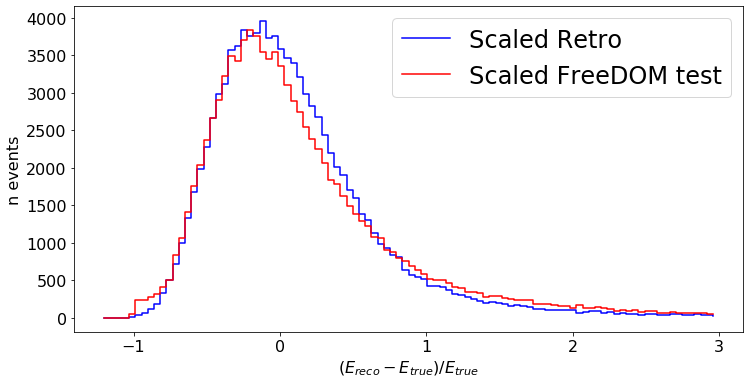

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-1.2, 3, 100)
for var, label, color in zip([cor_retro_E_rat, cor_freedom_E_rat], ['Scaled Retro', 'Scaled FreeDOM test'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    ax.step(bins[:-1], hist, where='post', label=label, color=color)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$(E_{reco} - E_{true}) / E_{true}$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

In [34]:
len(good_df)

100000

### log energy difference by bin in true energy

For total, tracks, and cascades

In [35]:
def e_binned_plot(e_bins, hist_bins, e_var, e_var_name, 
                  plot_vars, xlabel, xlim, plot_name=None,
                  figsize=(12, 12), colors=['blue', 'red'], 
                  legendfontsize=10, legendloc='best'):
    n_bins = len(e_bins) - 1
    
    gridsize = int(math.sqrt(n_bins))
    
    fig, axes = plt.subplots(nrows=gridsize, ncols=gridsize, figsize=figsize)
    plt.subplots_adjust(hspace=0.3)

    colors = color_cycle

    i = 0

    for ax, bin_limits in zip(axes.flat, zip(e_bins[:-1], e_bins[1:])):
        query = np.logical_and(e_var >= bin_limits[0], e_var < bin_limits[1])

        for var, label, color in zip(plot_vars, 
                                     ['Retro', 'FreeDOM'], colors):
            hist, bins = np.histogram(var[query], hist_bins)

            ax.step(bins[:-1], hist, where='post', label=label, color=color)

        ax.set_title(f'{bin_limits[0]:.0f} <= {e_var_name} < {bin_limits[1]:.0f}',
                    fontsize=16)

        ax.legend(loc=legendloc, fontsize=legendfontsize)

        if i // gridsize == gridsize - 1:
            ax.set_xlabel(xlabel, fontsize=16)
        else:
            pass
#             ax.set_xticklabels([])
            
        if i % gridsize == 0:
            ax.set_ylabel('n events', fontsize=16)
            
        ax.set_xlim(*xlim)

        ax.tick_params(labelsize=14)
        
        
        i += 1
    
    if plot_name is not None:
        fig.savefig(plot_name, bbox='tight')

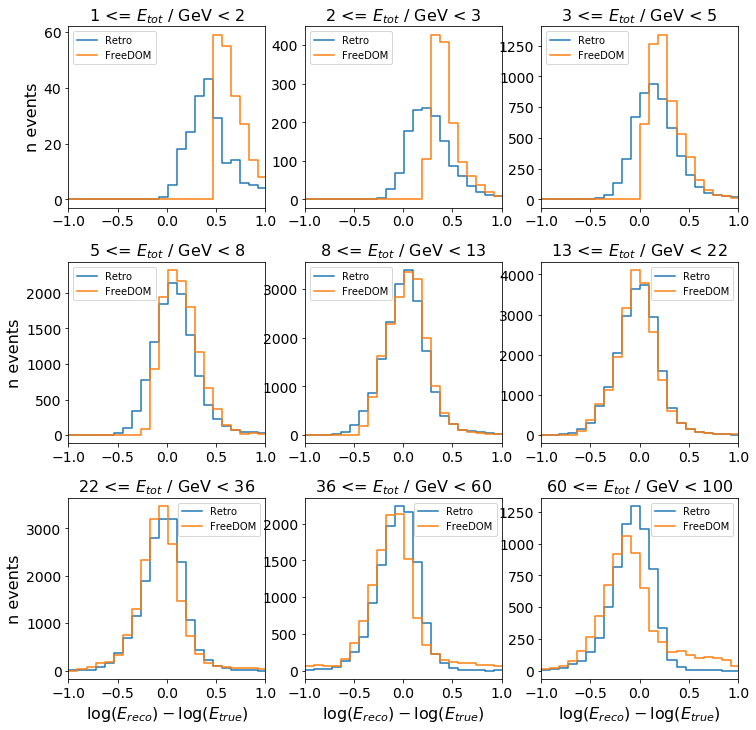

In [36]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-1, 1.2, 25)
e_binned_plot(e_bins, hist_bins, true_E_sums, '$E_{{tot}}$ / GeV', 
              [cor_retro_E_log_diff, cor_freedom_E_log_diff],
              '$\log(E_{reco}) - \log(E_{true})$',
              (-1, 1))

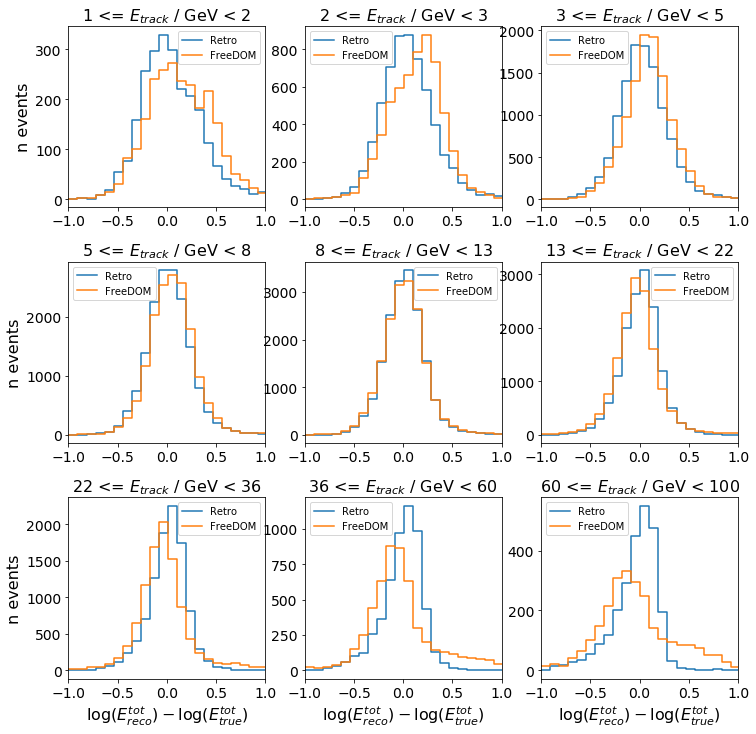

In [37]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-1, 1.2, 25)
e_binned_plot(e_bins, hist_bins, true_e[:, -1], '$E_{{track}}$ / GeV', 
              [cor_retro_E_log_diff, cor_freedom_E_log_diff],
              '$\log(E^{tot}_{reco}) - \log(E^{tot}_{true})$',
              (-1, 1))

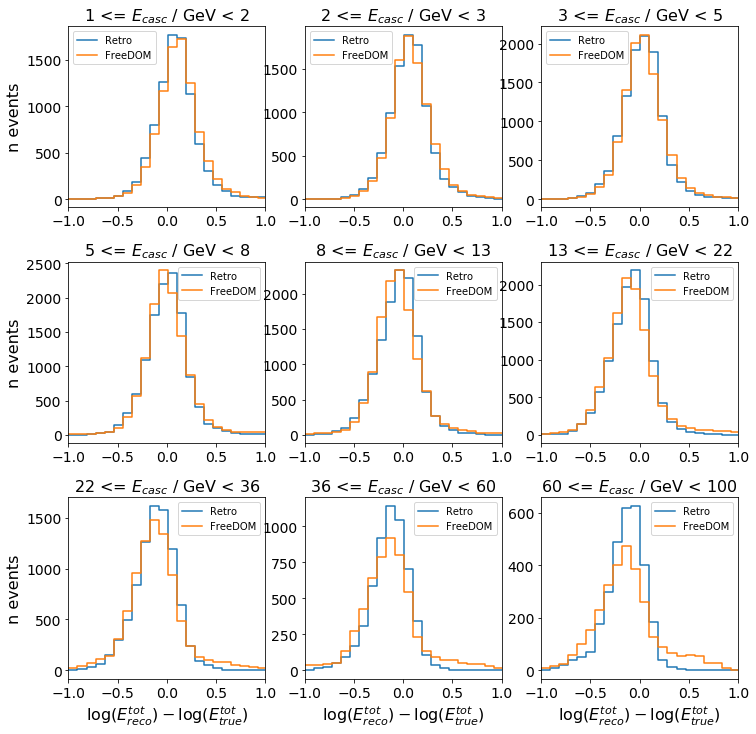

In [38]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-1, 1.2, 25)
e_binned_plot(e_bins, hist_bins, true_e[:, -2], '$E_{{casc}}$ / GeV', 
              [cor_retro_E_log_diff, cor_freedom_E_log_diff],
              '$\log(E^{tot}_{reco}) - \log(E^{tot}_{true})$',
              (-1, 1))

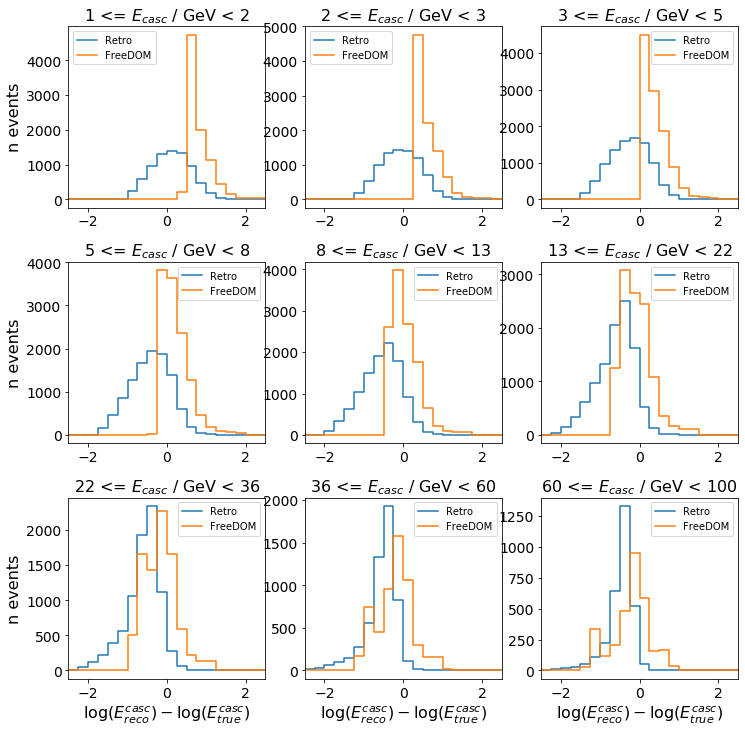

In [39]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-3, 3, 25)
e_binned_plot(e_bins, hist_bins, true_e[:,-2], '$E_{{casc}}$ / GeV', 
              [retro_cascade_log_e_rat, cascade_log_e_rat],
              '$\log(E^{casc}_{reco}) - \log(E^{casc}_{true})$',
              (-2.5, 2.5))

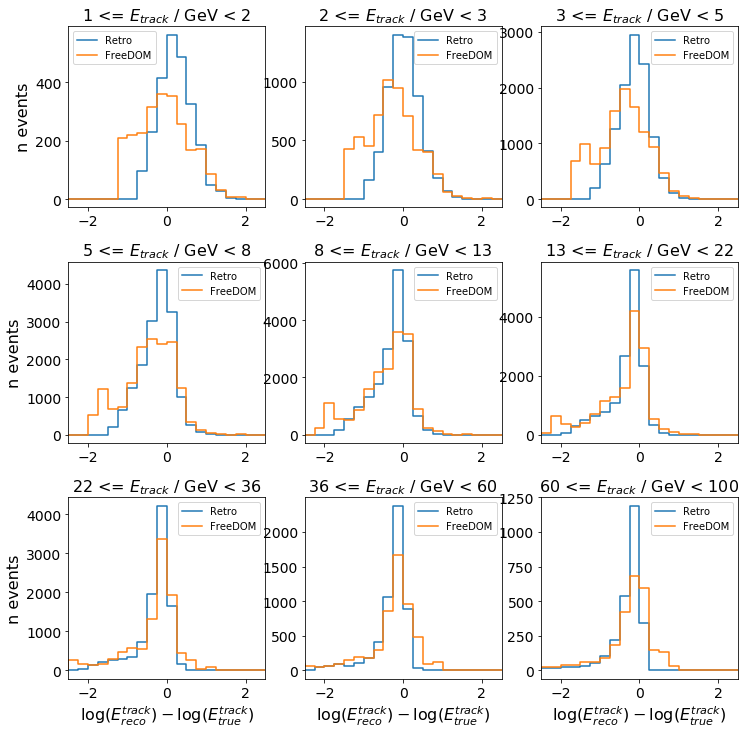

In [40]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-3, 3, 25)
e_binned_plot(e_bins, hist_bins, true_e[:,-1], '$E_{{track}}$ / GeV', 
              [retro_track_log_e_rat, track_log_e_rat],
              '$\log(E^{track}_{reco}) - \log(E^{track}_{true})$',
              (-2.5, 2.5))

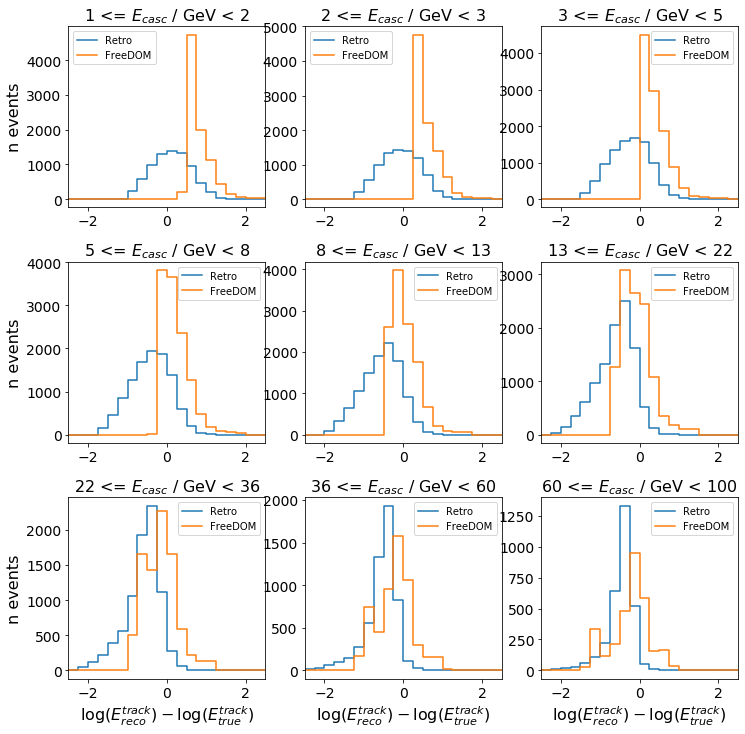

In [41]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-3, 3, 25)
e_binned_plot(e_bins, hist_bins, true_e[:,-2], '$E_{{casc}}$ / GeV', 
              [retro_cascade_log_e_rat, cascade_log_e_rat],
              '$\log(E^{track}_{reco}) - \log(E^{track}_{true})$',
              (-2.5, 2.5))

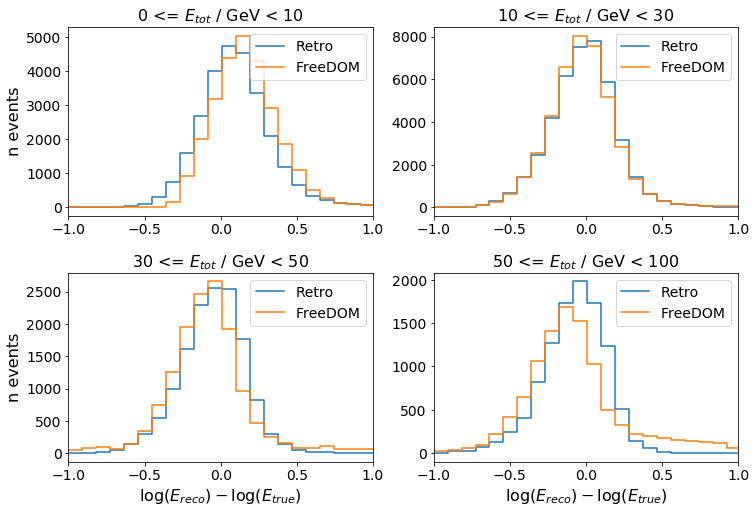

In [42]:
e_bins = [0, 10, 30, 50, 100]
hist_bins = np.linspace(-1, 1.2, 25)
e_binned_plot(e_bins, hist_bins, true_E_sums, '$E_{{tot}}$ / GeV', 
              [cor_retro_E_log_diff, cor_freedom_E_log_diff],
              '$\log(E_{reco}) - \log(E_{true})$',
              (-1, 1), figsize=(12, 8), colors=color_cycle, legendfontsize=14,
             legendloc='upper right', plot_name='pres_plots/e_reco_domnet.pdf')

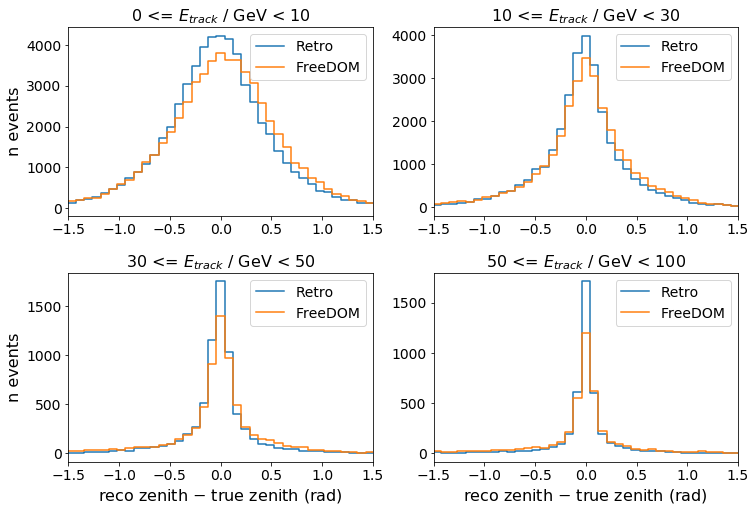

In [43]:
e_bins = [0, 10, 30, 50, 100]
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, true_e[:,-1], '$E_{{track}}$ / GeV', 
              [retro_zen_diff, freedom_zen_diff],
              'reco zenith $-$ true zenith (rad)',
              (-1.5, 1.5), figsize=(12,8), colors=color_cycle, legendfontsize=14, 
              legendloc='upper right', plot_name='pres_plots/zenith_reco_domnet.pdf')

### Scatter plot of best fit track energy vs best fit cascade energy

In [44]:
# to do

### Binned zenith resolution plot

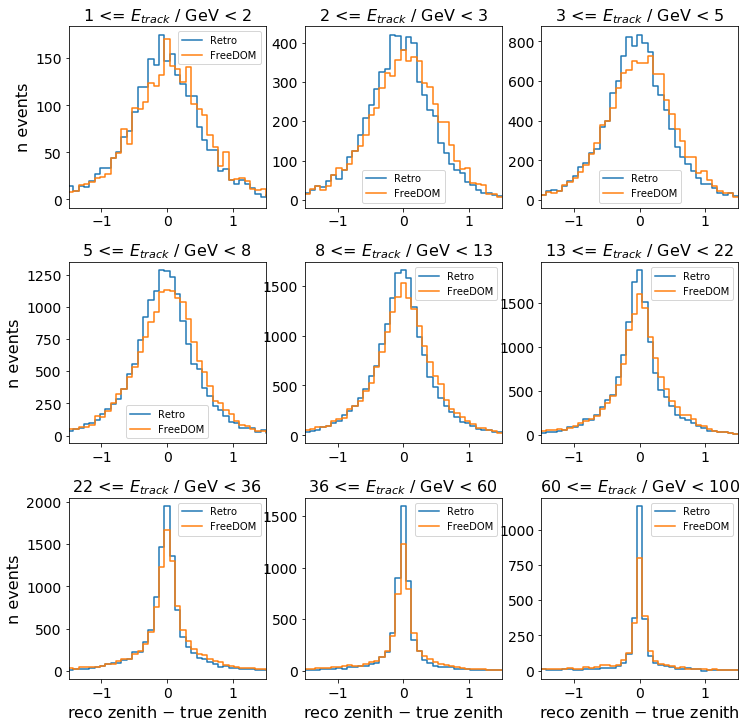

In [45]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, true_e[:,-1], '$E_{{track}}$ / GeV', 
              [retro_zen_diff, freedom_zen_diff],
              'reco zenith $-$ true zenith',
              (-1.5, 1.5))

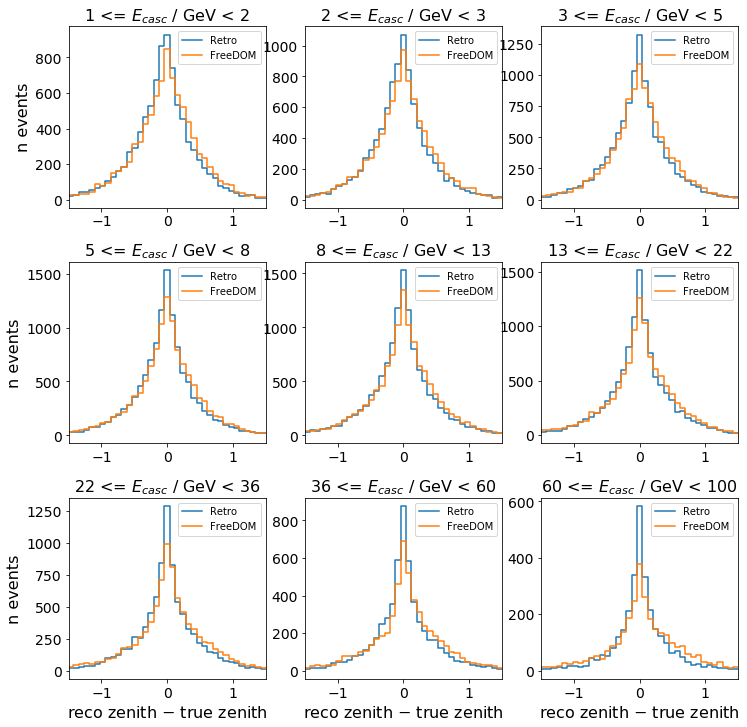

In [46]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, true_e[:,-2], '$E_{{casc}}$ / GeV', 
              [retro_zen_diff, freedom_zen_diff],
              'reco zenith $-$ true zenith',
              (-1.5, 1.5))

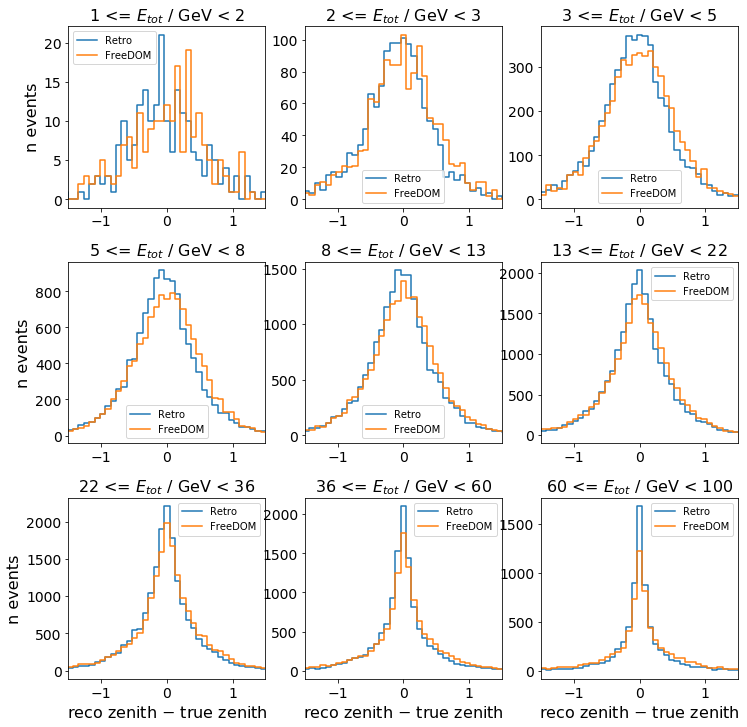

In [47]:
e_bins = np.logspace(0, 2, 10)
hist_bins = np.linspace(-2, 2, 50)

e_binned_plot(e_bins, hist_bins, true_E_sums, '$E_{{tot}}$ / GeV', 
              [retro_zen_diff, freedom_zen_diff],
              'reco zenith $-$ true zenith',
              (-1.5, 1.5))